In [369]:
%pip install netCDF4
%pip install zstandard
%pip install numcodecs
%pip install julia
%pip install xbitinfo
%pip install pooch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [370]:
import os
from netCDF4 import Dataset
import zstandard as zstd
import numcodecs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbitinfo as xb

In [371]:
def read_file_with_var(read_file_name, var_name, round):
    data = Dataset("data/" + read_file_name)

    var = data.variables[var_name]
    var_data = var[:]

    if round:
        var_rounded = var_data * 10 // 1 / 10
        output = var_rounded.tobytes()
        return output
    else:
        output = var_data.tobytes()
        return output

In [372]:
def stack_vars(read_file_name, var1, var2):
    data = Dataset("data/" + read_file_name)

    variable1 = data.variables[var1][:]
    variable2 = data.variables[var2][:]
    stacked = np.stack((variable1, variable2), axis=-1)
    
    output = stacked.tobytes()
    return output

In [373]:
def zstd_compress(data):
    cctx = zstd.ZstdCompressor()
    compressed = cctx.compress(data)
    return compressed

In [374]:
def zlib_compress(data):
    zlib = numcodecs.Zlib(level=9)
    compressed = zlib.encode(data)
    return compressed

In [375]:
def gzip_compress(data):
    gzip = numcodecs.gzip.GZip(level=9)
    compressed = gzip.encode(data)
    return compressed

In [376]:
def blosc_compress(data):
    blosc = numcodecs.Blosc(cname="blosclz", clevel=9, shuffle=numcodecs.blosc.Blosc.BITSHUFFLE, blocksize=0)
    compressed = blosc.encode(data)
    return compressed

In [377]:
def shuffle(data):
    shuffle = numcodecs.Shuffle()
    shuffled_data = shuffle.encode(data)
    return shuffled_data

In [378]:
def xbitinfo_round(data):
    ds = xr.open_dataset("data/" + data)
    ds = ds.drop_vars('TAITIME')
    bitinfo = xb.get_bitinformation(ds, dim="lon")
    keepbits = xb.get_keepbits(bitinfo, inflevel=0.99)
    ds_bitrounded = xb.xr_bitround(ds, keepbits)
    ds_bitrounded.to_compressed_netcdf("data/output/xbitinfo/" + data)

In [379]:
def get_file_size(file):
        file_size = len(file)
        return file_size

In [380]:
def compression_ratio(original_file, compressed_file,):
    original_size = get_file_size(original_file)
    compressed_size = get_file_size(compressed_file)

    ratio = round(original_size / compressed_size, 3)

    data = [original_size, compressed_size, ratio]
    return data

In [381]:
def compress_all_vars(read_file_name):
    data = Dataset("data/" + read_file_name)
    compression_ratios = {}
    size_comparison = {}

    for var_name in data.variables.keys():
        original = read_file_with_var(read_file_name, var_name, False)
        shuffled_data = shuffle(original)
        rounded_data = read_file_with_var(read_file_name, var_name, True)
        shuffle_and_rounded_data = shuffle(rounded_data)

        zstd_compressed_obj = zstd_compress(original)
        zstd_compression_data = compression_ratio(original, zstd_compressed_obj)

        zstd_compression_obj_shuffled = zstd_compress(shuffled_data)
        zstd_compression_data_shuffled = compression_ratio(original, zstd_compression_obj_shuffled)

        zstd_compression_obj_rounded = zstd_compress(rounded_data)
        zstd_compression_data_rounded = compression_ratio(original, zstd_compression_obj_rounded)

        zstd_compression_obj_shuffled_rounded = zstd_compress(shuffle_and_rounded_data)
        zstd_compression_data_shuffled_rounded = compression_ratio(original, zstd_compression_obj_shuffled_rounded)

        zlib_compressed_obj = zlib_compress(original)
        zlib_compression_data = compression_ratio(original, zlib_compressed_obj)

        zlib_compression_obj_shuffled = zlib_compress(shuffled_data)
        zlib_compression_data_shuffled = compression_ratio(original, zlib_compression_obj_shuffled)

        zlib_compression_obj_rounded = zlib_compress(rounded_data)
        zlib_compression_data_rounded = compression_ratio(original, zlib_compression_obj_rounded)

        zlib_compression_obj_shuffled_rounded = zlib_compress(shuffle_and_rounded_data)
        zlib_compression_data_shuffled_rounded = compression_ratio(original, zlib_compression_obj_shuffled_rounded)

        gzip_compressed_obj = gzip_compress(original)
        gzip_compression_data = compression_ratio(original, gzip_compressed_obj)

        gzip_compression_obj_shuffled = gzip_compress(shuffled_data)
        gzip_compression_data_shuffled = compression_ratio(original, gzip_compression_obj_shuffled)
        
        gzip_compression_obj_rounded = gzip_compress(rounded_data)
        gzip_compression_data_rounded = compression_ratio(original, gzip_compression_obj_rounded)

        gzip_compression_obj_shuffled_rounded = gzip_compress(shuffle_and_rounded_data)
        gzip_compression_data_shuffled_rounded = compression_ratio(original, gzip_compression_obj_shuffled_rounded)

        blosc_compressed_obj = blosc_compress(original)
        blosc_compression_data = compression_ratio(original, blosc_compressed_obj)

        blosc_compression_obj_shuffled = blosc_compress(shuffled_data)
        blosc_compression_data_shuffled = compression_ratio(original, blosc_compression_obj_shuffled)
        
        blosc_compression_obj_rounded = blosc_compress(rounded_data)
        blosc_compression_data_rounded = compression_ratio(original, blosc_compression_obj_rounded)

        blosc_compression_obj_shuffled_rounded = blosc_compress(shuffle_and_rounded_data)
        blosc_compression_data_shuffled_rounded = compression_ratio(original, blosc_compression_obj_shuffled_rounded)

        compression_ratios[var_name] = {
            "zstd_ratio": zstd_compression_data[2],
            "zstd_ratio_shuffled": zstd_compression_data_shuffled[2],
            "zstd_ratio_rounded": zstd_compression_data_rounded[2],
            "zstd_ratio_shuffled_rounded": zstd_compression_data_shuffled_rounded[2],
            "zlib_ratio": zlib_compression_data[2],
            "zlib_ratio_shuffled": zlib_compression_data_shuffled[2],
            "zlib_ratio_rounded": zlib_compression_data_rounded[2],
            "zlib_ratio_shuffled_rounded": zlib_compression_data_shuffled_rounded[2],
            "gzip_ratio": gzip_compression_data[2],
            "gzip_ratio_shuffled": gzip_compression_data_shuffled[2],
            "gzip_ratio_rounded": gzip_compression_data_rounded[2],
            "gzip_ratio_shuffled_rounded": gzip_compression_data_shuffled_rounded[2],
            "blosc_ratio": blosc_compression_data[2],
            "blosc_ratio_shuffled": blosc_compression_data_shuffled[2],
            "blosc_ratio_rounded": blosc_compression_data_rounded[2],
            "blosc_ratio_shuffled_rounded": blosc_compression_data_shuffled_rounded[2]
        }

        size_comparison[var_name] = {
            "original": zstd_compression_data[0],
            "zstd": zstd_compression_data[1],
            "zstd_shuffled": zstd_compression_data_shuffled[1],
            "zstd_rounded": zstd_compression_data_rounded[1],
            "zstd_shuffled_rounded": zstd_compression_data_shuffled_rounded[1],
            "zlib": zlib_compression_data[1],
            "zlib_shuffled": zlib_compression_data_shuffled[1],
            "zlib_rounded": zlib_compression_data_rounded[1],
            "zlib_shuffled_rounded": zlib_compression_data_shuffled_rounded[1],
            "gzip": gzip_compression_data[1],
            "gzip_shuffled": gzip_compression_data_shuffled[1],
            "gzip_rounded": gzip_compression_data_rounded[1],
            "gzip_shuffled_rounded": gzip_compression_data_shuffled_rounded[1],
            "blosc": blosc_compression_data[1],
            "blosc_shuffled": blosc_compression_data_shuffled[1],
            "blosc_rounded": blosc_compression_data_rounded[1],
            "blosc_shuffled_rounded": blosc_compression_data_shuffled_rounded[1]
        }

    data.close()

    ratio_write_path = "data/output/ratios/" + read_file_name + "_ratios.json"
    comparison_write_path = "data/output/comparison/" + read_file_name + "_comparison.json"
    os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    with open(ratio_write_path, "w") as outfile:
        json.dump(compression_ratios, outfile, indent=4)
        print(f"Compression ratios written to {ratio_write_path}")
    
    with open(comparison_write_path, "w") as outfile:
        json.dump(size_comparison, outfile, indent=4)
        print(f"File size comparisons written to {comparison_write_path}")

In [382]:
compress_all_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

Compression ratios written to data/output/ratios/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_ratios.json
File size comparisons written to data/output/comparison/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_comparison.json


In [383]:
xbitinfo_round("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")
original_size = os.path.getsize("data/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")
xbitinfo_size = os.path.getsize("data/output/xbitinfo/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

print(f"Original file size: {original_size} bytes")
print(f"Xbitinfo file size: {xbitinfo_size} bytes")

ratio = round(original_size / xbitinfo_size, 3)
print(f"Compression ratio: {ratio}")


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (28777) exception occured? None


Original file size: 10488337 bytes
Xbitinfo file size: 1569764 bytes
Compression ratio: 6.681


In [384]:
def original_ratio_plot(data):
    df = pd.DataFrame(data)

    original = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 1.5/len(categories)

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for i, method in enumerate(original.index):
        ax.bar(x + (i - len(categories)/2) * width, original.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])

    ax.set_title('Compression Ratios by Algorithm')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [385]:
def shuffled_ratio_plot(data):
    df = pd.DataFrame(data)

    non_shuffled = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]
    shuffled = df.loc[[col for col in df.index if 'shuffled' in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 0.1

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    shuffled_colors = ['#4a90e2', '#ffa07a', '#32cd32', '#ff6347']

    for i, method in enumerate(non_shuffled.index):
        ax.bar(x + i * (width * 2), non_shuffled.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])
        ax.bar(x + i * (width * 2) + width, shuffled.loc[method + '_shuffled'], width=width, 
            label=f'{method} Shuffled', alpha=0.7, color=shuffled_colors[i % len(shuffled_colors)])

    ax.set_title('Non-Shuffled vs Shuffled Compression Ratios')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [386]:
def rounded_ratio_plot(data):
    df = pd.DataFrame(data)
    df = df.drop(columns=["QLML"])

    non_rounded = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]
    rounded = df.loc[[col for col in df.index if 'rounded' in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 0.1

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    rounded_colors = ['#4a90e2', '#ffa07a', '#32cd32', '#ff6347']

    for i, method in enumerate(non_rounded.index):
        ax.bar(x + i * (width * 2), non_rounded.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])
        ax.bar(x + i * (width * 2) + width, rounded.loc[method + '_rounded'], width=width, 
            label=f'{method} Rounded', alpha=0.7, color=rounded_colors[i % len(rounded_colors)])

    ax.set_title('Non-Rounded vs Rounded Compression Ratios')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [387]:
def shuffle_rounded_ratio_plot(data):
    df = pd.DataFrame(data)
    df = df.drop(columns=["QLML"])

    non_shuffle_rounded = df.loc[[col for col in df.index if 'shuffled' not in col and 'rounded' not in col]]
    shuffle_rounded = df.loc[[col for col in df.index if 'shuffled_rounded' in col]]

    categories = df.columns
    x = np.arange(len(categories))
    width = 0.1

    fig, ax = plt.subplots(figsize=(12, 6))

    base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    rounded_colors = ['#4a90e2', '#ffa07a', '#32cd32', '#ff6347']

    for i, method in enumerate(non_shuffle_rounded.index):
        ax.bar(x + i * (width * 2), non_shuffle_rounded.loc[method], width=width, 
            label=f'{method} Original', alpha=0.7, color=base_colors[i % len(base_colors)])
        ax.bar(x + i * (width * 2) + width, shuffle_rounded.loc[method + '_shuffled_rounded'], width=width, 
            label=f'{method} Shuffled and Rounded', alpha=0.7, color=rounded_colors[i % len(rounded_colors)])

    ax.set_title('Shuffled and Rounded Compression Ratios')
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()

    return plt

In [388]:
def ratio_plots(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.json') and 'stacked' not in filename:
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    os.makedirs(directory_path, exist_ok=True)

                    original_plot = original_ratio_plot(data)
                    original_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_original.png')))

                    shuffle_plot = shuffled_ratio_plot(data)
                    shuffle_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_shuffle.png')))

                    rounded_plot = rounded_ratio_plot(data)
                    rounded_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_rounded.png')))

                    shuffle_rounded_plot = shuffle_rounded_ratio_plot(data)
                    shuffle_rounded_plot.savefig(os.path.join(directory_path, filename.replace('.json', '_shuffle_rounded.png')))

                    original_plot.show()
                    shuffle_plot.show()
                    rounded_plot.show()
                    shuffle_rounded_plot.show()

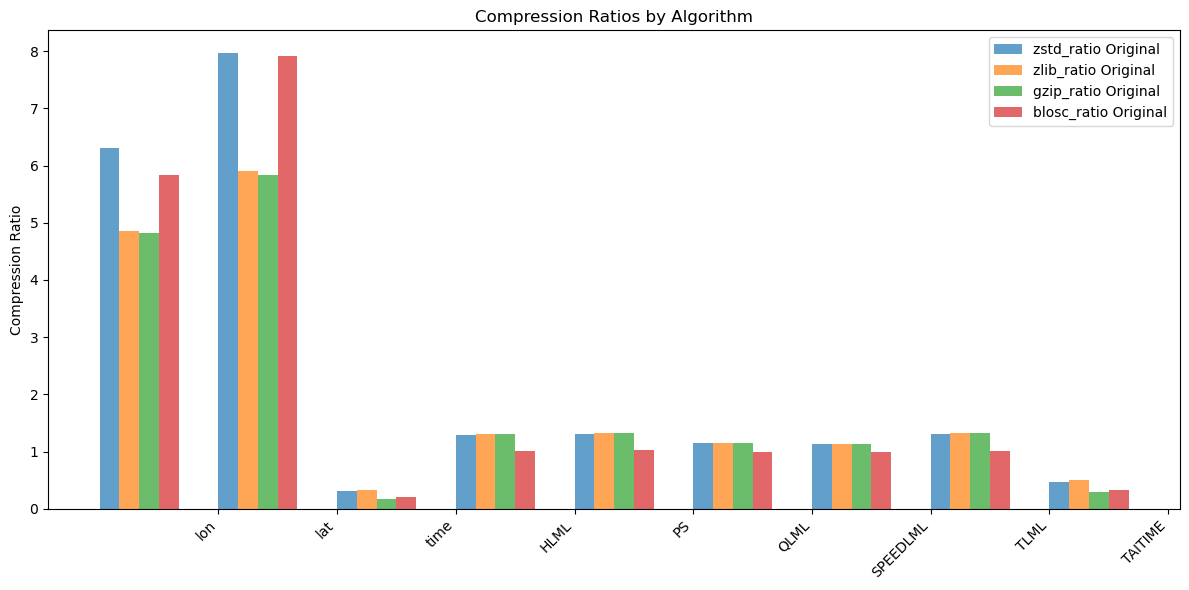

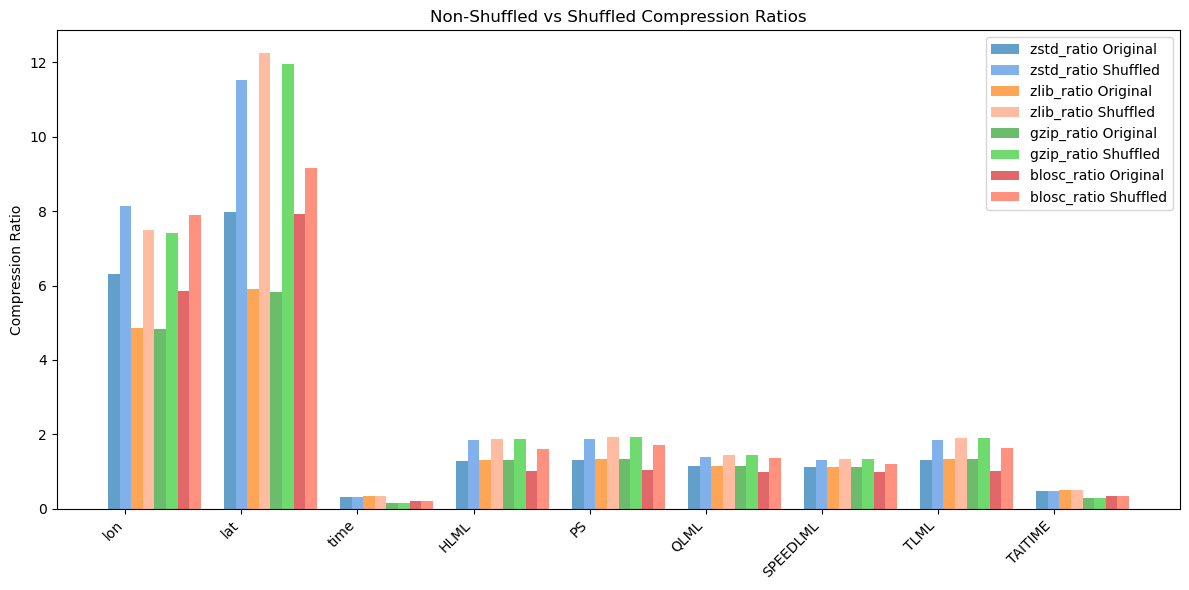

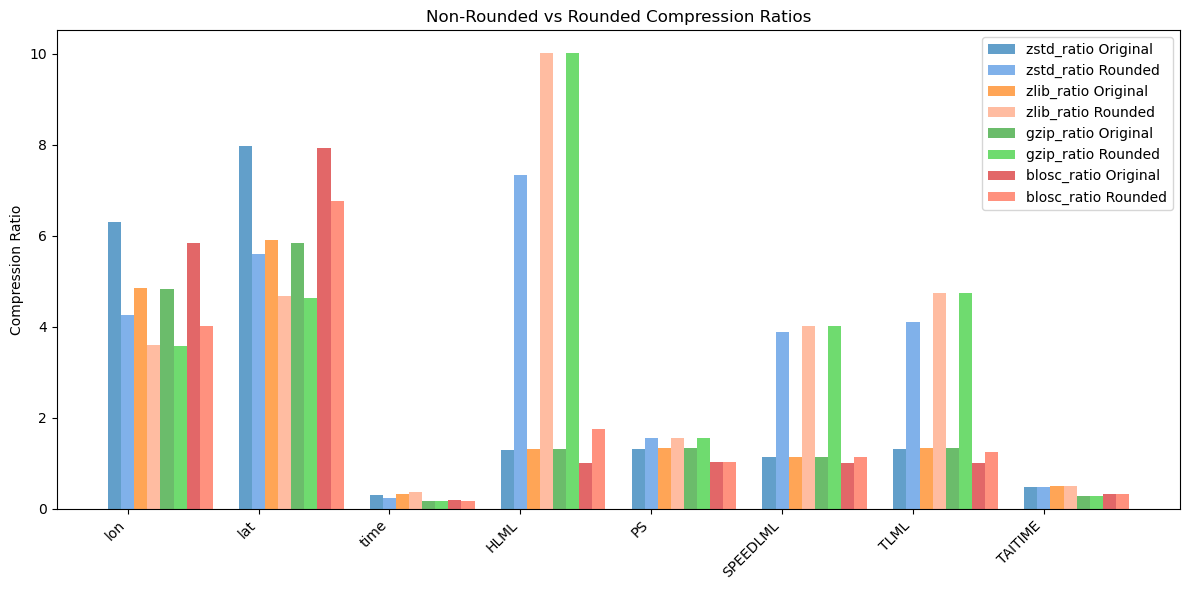

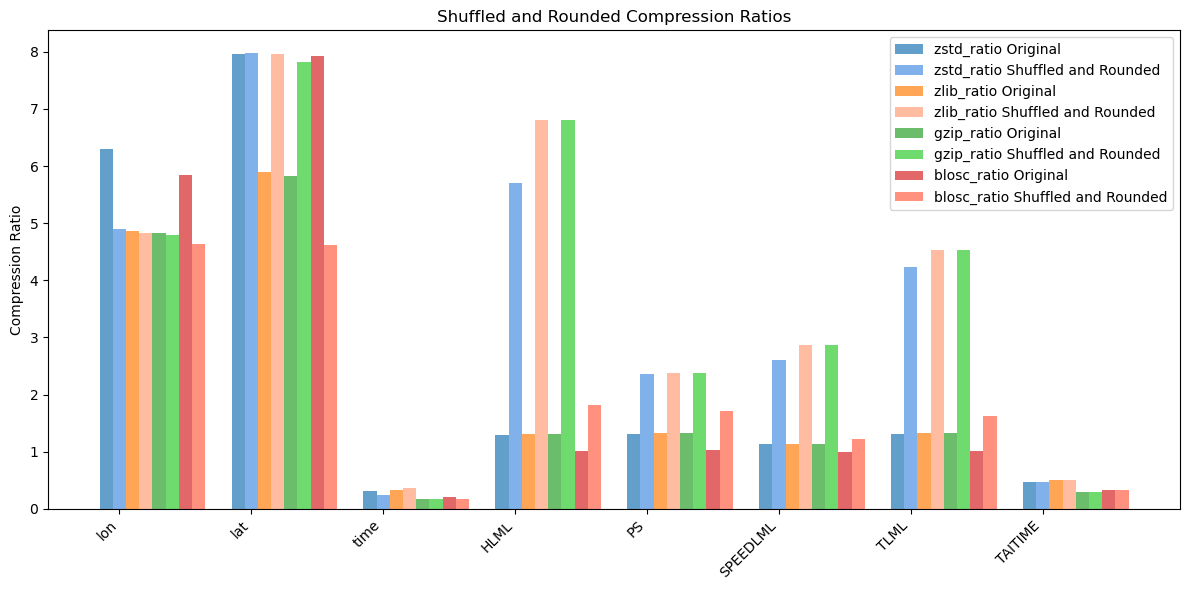

In [389]:
ratio_plots("data/output/ratios/")

In [390]:
# def comparison_plot(directory_path):
#     for filename in os.listdir(directory_path):
#         if filename.endswith('.json'):
#             file_path = os.path.join(directory_path, filename)
            
#             if os.path.isfile(file_path):
#                 with open(file_path, 'r') as file:
#                     data = json.load(file)

#                     keys = list(data.keys())
#                     libraries = [lib for lib in data[keys[0]].keys() if lib != "original"]
                    
#                     original_values = [data[key]['original'] for key in keys]
                    
#                     compressed_values = {lib: [data[key][lib] for key in keys] for lib in libraries}

#                     x = np.arange(len(keys))
#                     width = 0.8 / (len(libraries) + 1)

#                     fig, ax = plt.subplots(figsize=(12, 6))

#                     ax.bar(x - len(libraries)/2 * width, original_values, width, label='Original', color='skyblue')

#                     for i, lib in enumerate(libraries):
#                         ax.bar(x + (i + 1 - len(libraries) / 2) * width, compressed_values[lib], width, label=lib)

#                     ax.set_xlabel('Keys')
#                     ax.set_ylabel('Size')
#                     ax.set_title('Original vs Compressed Sizes by Library')
#                     ax.set_xticks(x)
#                     ax.set_xticklabels(keys, rotation=45)
#                     ax.legend()

#                     plt.tight_layout()

#                     output_dir = "data/output/comparison/"
#                     os.makedirs(output_dir, exist_ok=True)
#                     plt.savefig(os.path.join(output_dir, filename.replace('.json', '.png')))
#                     plt.show()

In [391]:
def compress_all_stacked_vars(read_file_name):
    data = Dataset("data/" + read_file_name)
    compression_ratios = {}
    size_comparison = {}

    for var1_name in data.variables.keys():
        for var2_name in list(data.variables.keys())[list(data.variables.keys()).index(var1_name) + 1:]:
            skip = ["TAITIME", "time", "lon", "lat"]
            if var1_name in skip or var2_name in skip:
                continue

            original = stack_vars(read_file_name, var1_name, var2_name)
    
            zstd_compressed_obj = zstd_compress(original)
            zstd_compression_data = compression_ratio(original, zstd_compressed_obj)

            zlib_compressed_obj = zlib_compress(original)
            zlib_compression_data = compression_ratio(original, zlib_compressed_obj)

            gzip_compressed_obj = gzip_compress(original)
            gzip_compression_data = compression_ratio(original, gzip_compressed_obj)

            blosc_compressed_obj = blosc_compress(original)
            blosc_compression_data = compression_ratio(original, blosc_compressed_obj)

            compression_ratios[var1_name + "+" + var2_name] = {
                "zstd_ratio": zstd_compression_data[2],
                "zlib_ratio": zlib_compression_data[2],
                "gzip_ratio": gzip_compression_data[2],
                "blosc_ratio": blosc_compression_data[2],
            }

            size_comparison[var1_name + "+" + var2_name] = {
                "original": zstd_compression_data[0],
                "zstd": zstd_compression_data[1],
                "zlib": zlib_compression_data[1],
                "gzip": gzip_compression_data[1],
                "blosc": blosc_compression_data[1],
            }

    data.close()

    ratio_write_path = "data/output/ratios/" + read_file_name + "_stacked_ratios.json"
    comparison_write_path = "data/output/comparison/" + read_file_name + "_stacked_comparison.json"
    os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    with open(ratio_write_path, "w") as outfile:
        json.dump(compression_ratios, outfile, indent=4)
        print(f"Compression ratios written to {ratio_write_path}")
    
    with open(comparison_write_path, "w") as outfile:
        json.dump(size_comparison, outfile, indent=4)
        print(f"File size comparisons written to {comparison_write_path}")

In [392]:
compress_all_stacked_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

Compression ratios written to data/output/ratios/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_stacked_ratios.json
File size comparisons written to data/output/comparison/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_stacked_comparison.json


In [393]:
def stacked_ratio_plot(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.json') and 'stacked' in filename:
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    os.makedirs(directory_path, exist_ok=True)

                    compression_methods = list(next(iter(data.values())).keys())

                    plot_data = {method: [] for method in compression_methods}
                    labels = []

                    for label, ratios in data.items():
                        labels.append(label)
                        for method in compression_methods:
                            plot_data[method].append(ratios[method])

                    x = np.arange(len(labels))
                    width = 0.15

                    fig, ax = plt.subplots(figsize=(12, 6))

                    for i, method in enumerate(compression_methods):
                        ax.bar(x + i * width, plot_data[method], width, label=method)

                    ax.set_title('Compression Ratios for Different Combinations')
                    ax.set_xlabel('Combination')
                    ax.set_ylabel('Compression Ratio')
                    ax.set_xticks(x + width * (len(compression_methods) - 1) / 2)  # Center the ticks
                    ax.set_xticklabels(labels, rotation=45, ha='right')
                    ax.legend()

                    plt.tight_layout()
                    plt.savefig(os.path.join(directory_path, filename.replace('.json', '_stacked.png')))
                    plt.show()

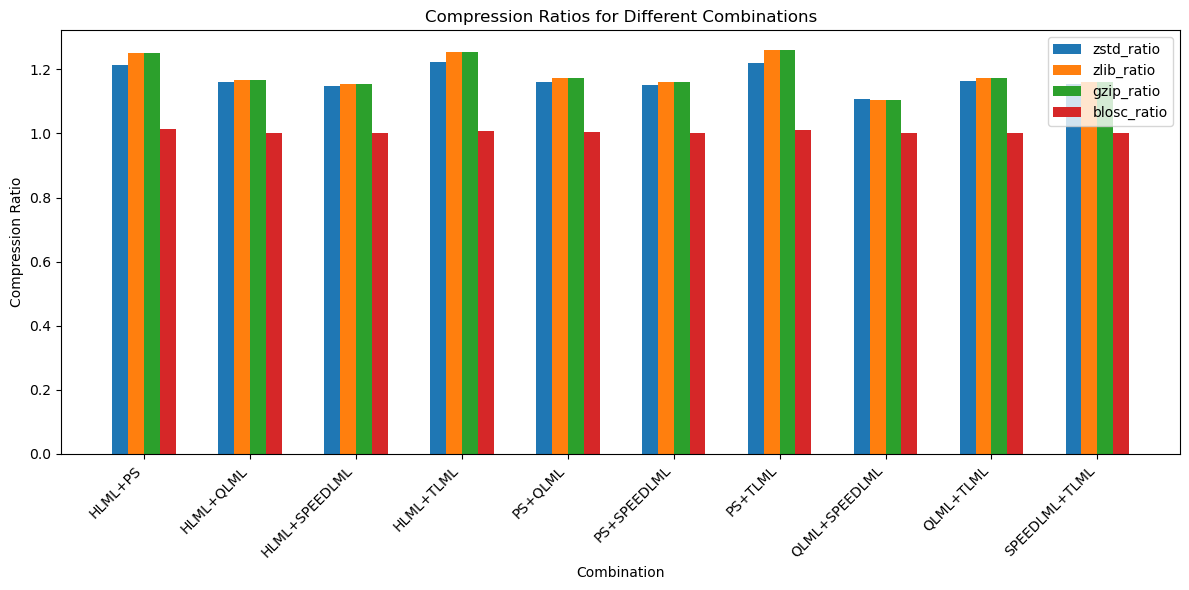

In [394]:
stacked_ratio_plot("data/output/ratios/")